In [4]:
FILE_PATH = '../atus/ehresp_2014.xlsx'

# Import libraries
import pandas as pd

# Load the ehresp_2014 DataFrame
ehresp_2014 = pd.read_excel(FILE_PATH)

from enum import Enum
class FEATURE_SELECTION_OPTIONS(Enum):
    K_BEST = 'k_best',
    NONE = 'none'

def do_the_stuff(feature_selection_option):
    from enum import Enum
    class COLUMN_TYPES(Enum):
        NUMERICAL = 'numerical',
        CATEGORICAL = 'categorical'

    numerical_columns = ['ertpreat', \
                         'ertseat', \
                         'euexfreq', \
                         'eufastfdfrq', \
                         'euhgt', \
                         'euwgt']

    categorical_columns = ['eeincome1', \
                           'erhhch', \
                           'erincome', \
                           'erspemch', \
                           'ethgt', \
                           'etwgt', \
                           'eudietsoda', \
                           'eudrink', \
                           'eueat', \
                           'euexercise', \
                           'eufastfd', \
                           'euffyday', \
                           'eufdsit', \
                           'eusnap', \
                           'eugenhth', \
                           'eugroshp', \
                           'euinclvl', \
                           'euincome2', \
                           'eumeat', \
                           'eumilk', \
                           'euprpmel', \
                           'eusoda', \
                           'eustores', \
                           'eustreason', \
                           'eutherm', \
                           'euwic']

    target_column = ['erbmi']

    def split_data(dataset):
        import numpy as np
        length = dataset.shape[0]
        train_index_stop = int(length * 0.7)
        permutation = np.random.RandomState(0).permutation(length)

        # Take just the values up to the train_index_stop
        train_permutation = permutation[:train_index_stop]
        # Take the values after the train_index_stop
        test_permutation = permutation[train_index_stop:]

        # Create the training and testing data
        dataset_train = dataset[train_permutation]
        dataset_test = dataset[test_permutation]

        return [dataset_train, dataset_test]

    def prepare_categorical_columns(file, columns):
        import pandas as pd
        from sklearn.preprocessing import LabelEncoder

        # Extract columns from file; convert to array
        dataset = file[columns].values

        # Apply LabelEncoder to multiple columns: https://stackoverflow.com/a/31939145
        dataset = pd.DataFrame(dataset).apply(LabelEncoder().fit_transform).values

        # OHE for multiple columns using pd.get_dummies: https://stackoverflow.com/a/44601764
        # Another get_dummies example: http://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example
        # OHE vs. get_dummies: https://medium.com/@guaisang/handling-categorical-features-get-dummies-onehotencoder-and-multicollinearity-f9d473a40417
        dataset_df = pd.DataFrame(dataset, columns=columns)
        # Keep only the columns we want, and drop the extraneous dummy column
        dataset_dummies = pd.get_dummies(dataset_df,
                                         columns=columns,
                                         drop_first=True)
        dataset = dataset_dummies.values

        # Split dataset
        dataset_train, dataset_test = split_data(dataset)

        return [dataset_train, dataset_test]

    def prepare_numerical_columns(file, columns):
        # Extract columns from file; convert to array
        dataset = file[columns].values

        # Split dataset
        X_train, X_test = split_data(dataset)

        # Scale values
        from sklearn.preprocessing import StandardScaler
        sc_X = StandardScaler()
        X_train = sc_X.fit_transform(X_train)
        X_test = sc_X.transform(X_test)

        return [X_train, X_test]

    # Define a function to return BMI class
    def get_bmi_class(bmi):
        if bmi < 18.5:
            return "Excellent"
        elif bmi >= 18.5 and  bmi < 24.9:
            return "Normal Weight"
        elif bmi >= 24.9 and bmi < 29.9:
            return "Overweight"
        elif bmi > 30:
            return "Obese"
        else:
            return "Unknown"
    # def get_bmi_class(bmi):
    #     if bmi < 18.5:
    #         return 0
    #     elif bmi >= 18.5 and  bmi < 24.9:
    #         return 1
    #     elif bmi >= 24.9 and bmi < 29.9:
    #         return 0
    #     elif bmi > 30:
    #         return 0
    #     else:
    #         return 0

    def prepare_target_column(file, column, return_column_type):
        import numpy as np
        import pandas as pd
        dataset = file[column].values

        if (return_column_type == COLUMN_TYPES.CATEGORICAL):
            dataset = np.asarray(pd.Series(get_bmi_class(bmi) for bmi in dataset))

        # Split dataset
        dataset_train, dataset_test = split_data(dataset)

        return [dataset_train, dataset_test]


    def prepare_data(file,
                     categorical_columns,
                     numerical_columns,
                     target_column,
                     target_column_return_type):
        print('\nBegin prepare_data')
        import pandas as pd
        X_categorical_train, \
        X_categorical_test = prepare_categorical_columns(file, categorical_columns)

        X_numerical_train, \
        X_numerical_test = \
        prepare_numerical_columns(file, numerical_columns)

        X_train = pd.DataFrame(X_numerical_train) \
        .merge(pd.DataFrame(X_categorical_train),
               how='outer',
               left_index=True,
               right_index=True) \
        .values
        print('X_train shape:', X_train.shape)

        X_test = pd.DataFrame(X_numerical_test) \
        .merge(pd.DataFrame(X_categorical_test),
               how='outer',
               left_index=True,
               right_index=True) \
        .values
        print('X_test shape:', X_test.shape)

        y_train, \
        y_test = \
        prepare_target_column(file, target_column, target_column_return_type)

        print('y_train shape:', y_train.shape)
        print('y_test shape:', y_test.shape)

        print('End prepare_data()\n')
        return [X_train, X_test, y_train, y_test]

    X_train, X_test, \
    y_train, y_test = \
    prepare_data(file = ehresp_2014,
                 categorical_columns = categorical_columns,
                 numerical_columns = numerical_columns,
                 target_column = target_column,
                 target_column_return_type = COLUMN_TYPES.CATEGORICAL)

    def drop_columns_with_only_zero_values(X_train, X_test):
        print('\nBegin drop_columns_with_only_zero_values()')
        # Drop columns where all values are `0`: https://stackoverflow.com/questions/34007632/how-to-remove-a-column-in-a-numpy-array/34008274
        import numpy as np
        print('X_train.shape', X_train.shape)
        print('X_test.shape', X_test.shape)
        print(np.std(X_train, axis=0) != 0)

        non_zero_columns_in_X_train = np.std(X_train, axis=0) != 0

        X_train = X_train[:, non_zero_columns_in_X_train]
        print('X_train.shape - after dropping `0` columns', X_train.shape)
        X_test = X_test[:, non_zero_columns_in_X_train]
        print('X_test.shape - after dropping `0` columns', X_test.shape)

        print('End drop_columns_with_only_zero_values()\n')
        return [X_train, X_test]

    X_train, X_test = drop_columns_with_only_zero_values(X_train = X_train,
                                                         X_test = X_test)

    if(feature_selection_option == FEATURE_SELECTION_OPTIONS.K_BEST):
        def select_k_best_categorical_features(X_train,
                                               y_train,
                                               X_test,
                                               first_categorical_column_index,
                                               k_best,
                                               score_function):
            print('\nBegin select_k_best_categorical_features()')
            from sklearn.feature_selection import SelectKBest
            import numpy as np

            print('Before selection: X_train.shape', X_train.shape)

            select_k_best = SelectKBest(score_func = score_function, k = k_best)
            fit = select_k_best.fit(X_train[:, first_categorical_column_index:], y_train)

            def transform(arr, fit, first_categorical_column_index):
                arr_numerical = arr[:, :first_categorical_column_index]
                arr_categorical = arr[:, first_categorical_column_index:]
                features = fit.transform(arr_categorical)
                return np.append(arr_numerical, features, axis=1)

            X_train = transform(arr = X_train,
                                fit = fit,
                                first_categorical_column_index = first_categorical_column_index)

            print('After selection: X_train.shape', X_train.shape)
            print('After selection: X_train:\n', X_train)

            print('Before selection: X_test.shape', X_test.shape)
            X_test = transform(arr = X_test,
                               fit = fit,
                               first_categorical_column_index = first_categorical_column_index)
            print('After selection: X_test.shape', X_test.shape)
            print('After selection: X_test:\n', X_test)

            print('End select_k_best_categorical_features()\n')
            return [X_train, X_test]


        # https://www.datacamp.com/community/tutorials/feature-selection-python
        # Note that `chi2` works _only_ for non-negative categorical data
        from sklearn.feature_selection import chi2

        X_train, X_test = select_k_best_categorical_features(X_train = X_train,
                                                             y_train = y_train,
                                                             X_test = X_test,
                                                             first_categorical_column_index = 6, 
                                                             k_best = 10,
                                                             score_function = chi2)
        
    
    return [X_train, X_test, y_train, y_test]

X_train, X_test, \
y_train, y_test = do_the_stuff(feature_selection_option = FEATURE_SELECTION_OPTIONS.NONE)


Begin prepare_data
X_train shape: (7848, 116)
X_test shape: (3364, 116)
y_train shape: (7848,)
y_test shape: (3364,)
End prepare_data()


Begin drop_columns_with_only_zero_values()
X_train.shape (7848, 116)
X_test.shape (3364, 116)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
X_train.shape - after dropping `0` columns (7848, 116)
X_tes

/Users/ehelander/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


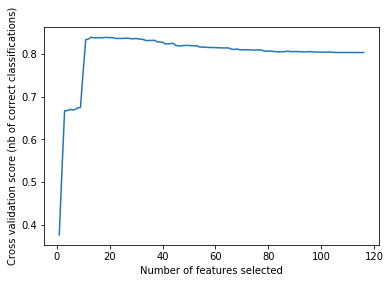

The highest accuracy, 0.8384, is achieved with 12 features.
Ranking of features (`1` indicates selected):
 [ 96  95  93  80   1   1  70  97  88  62  63  69  68  61  92  94  60  91
  67  76  86  31  75   1   1   1   1  81   1  52   1  66  30  77  20   1
  15   8  10   9  64 101   4   5  42 103   1  41  87   1  39  40  49  98
  13  12  11  14  99   6   7  72 100  29  45  74  73  65  51  25  58  26
  82  37  71  85  89  59  32   3  48  90  16  34  33 104 102  18  35  17
   1   1  78  50  27  57  56  55  19  38  53  24  84  83  79  44  43  54
  36   2  46  47  28  22  23  21]


In [5]:
def get_optimum_features(X_train,
                         y_train,
                         estimator,
                         cv,
                         scoring):
    # https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
    from sklearn.feature_selection import RFECV

    rfecv = RFECV(estimator,
                  step = 1,
                  cv = cv,
                  scoring = scoring
                 )

    rfecv.fit(X_train, y_train)
    
    # Plot number of features VS. cross-validation scores
    import matplotlib.pyplot as plt
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    import numpy as np
    print('The highest accuracy, %2.4f, is achieved with %2d features.' % (np.amax(rfecv.grid_scores_), np.argmax(rfecv.grid_scores_)))
    
    print('Ranking of features (`1` indicates selected):\n', rfecv.ranking_)
    
    return rfecv

from sklearn.linear_model import LogisticRegression
estimator = LogisticRegression(random_state=0)
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(2)
scoring = 'accuracy'

output = get_optimum_features(X_train,
                              y_train,
                              estimator, 
                              cv,
                              scoring)